# 5 GLMの尤度比検定と検定の非対称性

In [1]:
using CSV
using GLM
using Plots
using StatsBase
using Statistics

In [2]:
df = CSV.read("data3a.csv");

### 5.4.1 方法(1) 汎用性のあるパラメトリックブートストラップ法
一定モデル

In [3]:
fit1 = glm(@formula(y ~ 1), df, Poisson())

StatsModels.DataFrameRegressionModel{GeneralizedLinearModel{GlmResp{Array{Float64,1},Poisson{Float64},LogLink},DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: y ~ +1

Coefficients:
             Estimate Std.Error z value Pr(>|z|)
(Intercept)   2.05796 0.0357371 57.5862   <1e-99


xモデル

In [4]:
fit2 = glm(@formula(y ~ x), df, Poisson())

StatsModels.DataFrameRegressionModel{GeneralizedLinearModel{GlmResp{Array{Float64,1},Poisson{Float64},LogLink},DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: y ~ 1 + x

Coefficients:
              Estimate Std.Error z value Pr(>|z|)
(Intercept)    1.29172  0.363686 3.55174   0.0004
x            0.0756619 0.0356042 2.12509   0.0336


### 残差逸脱度の差

In [5]:
deviance(fit1) - deviance(fit2)

4.513941078851829

### 真のモデルから100個体分のデータを新しく生成

In [6]:
df.y_rnd = rand(Poisson(mean(df.y)), 100)

100-element Array{Int64,1}:
  7
  6
 10
  9
  7
  4
  4
  7
  7
 10
  4
  5
  7
  ⋮
  5
  6
 13
 14
 11
 12
  8
  9
 10
  8
  6
  4

### 一定モデルとxモデルをこの真データに当てはめる

In [7]:
fit1 = glm(@formula(y_rnd ~ 1), df, Poisson())
fit2 = glm(@formula(y_rnd ~ x), df, Poisson())
deviance(fit1) - deviance(fit2)

1.189020424934796

### PB法を実行する関数
データの生成と逸脱度差の評価

In [8]:
function get_dd(df)
    n_samples = size(df, 1)
    y_mean = mean(df.y)
    df.y_rnd = rand(Poisson(y_mean), n_samples)
    fit1 = glm(@formula(y_rnd ~ 1), df, Poisson())
    fit2 = glm(@formula(y_rnd ~ x), df, Poisson())
    deviance(fit1) - deviance(fit2)
end

get_dd (generic function with 1 method)

In [9]:
function pb(df, n_bootstrap)
    [get_dd(df) for _ in 1:n_bootstrap]
end

pb (generic function with 1 method)

### 逸脱度の差のサンプルを1000個を作成

In [10]:
dd12 = pb(df, 1000)

1000-element Array{Float64,1}:
 1.1486303244452358  
 1.2379143349800472  
 1.2867198382396623  
 0.3511088318944786  
 0.17412789949815988 
 0.000811551981911407
 0.2857821265328795  
 0.05591170539449308 
 1.9994458341597436  
 0.017207438999037095
 0.24567352366568684 
 0.3779673222890807  
 0.05990015905760515 
 ⋮                   
 0.004638528845788414
 5.585730797733419   
 1.7980378372794519  
 1.8555270906410186  
 0.5715930980171464  
 5.197761267675872   
 0.010076028839890228
 0.25846395166242075 
 0.7479123098301983  
 0.6692151464064295  
 0.11823858683075628 
 0.26236143376769405 

In [11]:
describe(dd12)

Summary Stats:
Mean:           0.981152
Minimum:        0.000001
1st Quartile:   0.105289
Median:         0.442494
3rd Quartile:   1.310634
Maximum:        11.279349
Length:         1000
Type:           Float64


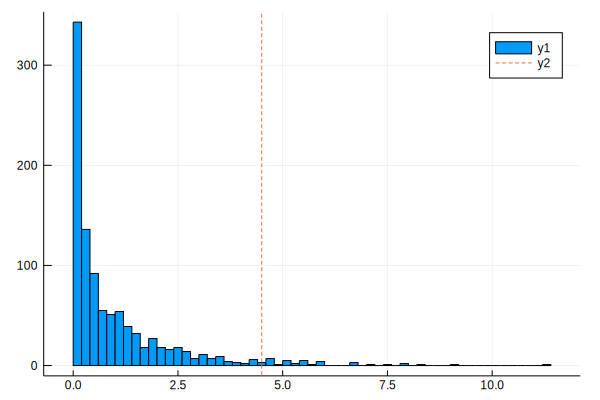

In [12]:
histogram(dd12, bins=100)
plot!([4.5], seriestype=:vline, linestyle=:dash)

合計1000個の$\Delta D_{1,2}$のうちいくつが4.5より右にあるか

In [13]:
sum(dd12 .>= 4.5)

36

$P=0.05$となる逸脱度の差

In [14]:
quantile(dd12, 0.95)

3.7152435329931905

### 方法(2) $\chi^2$分布を使った近似計算法

In [15]:
fit1 = glm(@formula(y_rnd ~ 1), df, Poisson())
fit2 = glm(@formula(y_rnd ~ x), df, Poisson())

StatsModels.DataFrameRegressionModel{GeneralizedLinearModel{GlmResp{Array{Float64,1},Poisson{Float64},LogLink},DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: y_rnd ~ 1 + x

Coefficients:
               Estimate Std.Error   z value Pr(>|z|)
(Intercept)     2.26033  0.357048    6.3306    <1e-9
x            -0.0180691 0.0352789 -0.512178   0.6085


TODO  
anova